In [1]:
import sys 
import os
module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)
import pandas as pd
import seaborn as sns
from pathlib import Path
from utils.mlflow_query import MlflowHelper
from utils.percentiles import calculate_accuracies_per_percentiles, plot_accuracies_per_percentiles
import math

In [4]:
mlflow_helper = MlflowHelper(pkl_file=None, 
    local_mlflow_dir_prefix='/home/i40/almasrirz/Domain-Guided-Monitoring/mlruns/', 
    experiment_id="831333387297563441",
    tracking_uri="http://localhost:5100")
mlflow_helper.query_runs()

Querying data per run...: 100%|██████████| 4073/4073 [05:16<00:00, 12.86it/s] 


In [5]:
def plot_best_metric_bar(metric_df, metric_names,
    x_feature_name='data_tags_model_type', 
    x_order=['simple', 'causal_heuristic', 'causal_score'],
    save_fig = False,
    row_feature_name=None,
    hue_feature_name=None,
    col_feature_name=None,
    titles=None,
    palette=None,
    dodge=True,
    col_order=None
):
    for metric_name in metric_names:
        g = sns.catplot(
            data=metric_df, x=x_feature_name, y=metric_name, order=x_order,
            row=row_feature_name, hue=hue_feature_name, col=col_feature_name, col_order=col_order,
            kind="box", sharey='row', palette=palette, dodge=dodge,
        )
        g.set_titles(titles).set_axis_labels('', metric_name)
        for ax in g.axes.flatten():
            ax.tick_params(labelbottom=True)
        if save_fig:
            g.savefig("bar_{}.png".format(metric_name))


In [6]:
def count_attributes(df: pd.DataFrame, attr='data_tags_model_type'):
    return df.groupby([attr])[attr].count()

# Lena's Results

In [7]:
lena_df = mlflow_helper.run_df[
    (mlflow_helper.run_df['data_params_ExperimentConfigmax_data_size'] == '-1')
    & (mlflow_helper.run_df['data_tags_model_type'].isin(['causal_heuristic', 'simple', 'hierarchy', 'text']))
    & (mlflow_helper.run_df['data_params_HuaweiPreprocessorConfigaggregated_log_file'] == 'data/logs_aggregated_concurrent_original.csv')
]
lena_df = mlflow_helper.load_best_metrics_for_ids(set(lena_df['info_run_id']))
lena_df.loc[lena_df['data_params_HuaweiPreprocessorConfigremove_dates_from_payload'] == 'False', 
'data_tags_model_type'] = lena_df.loc[lena_df['data_params_HuaweiPreprocessorConfigremove_dates_from_payload'] == 'False', 
'data_tags_model_type'].apply(lambda x: x + "_with_ts")

Querying metrics for runs: 100%|██████████| 128/128 [00:14<00:00,  8.94it/s]


In [8]:
count_attributes(lena_df)

data_tags_model_type
causal_heuristic             3
causal_heuristic_with_ts    20
hierarchy                   28
hierarchy_with_ts            8
simple                      20
simple_with_ts              20
text                        21
text_with_ts                 8
Name: data_tags_model_type, dtype: int64

### With Timestamps

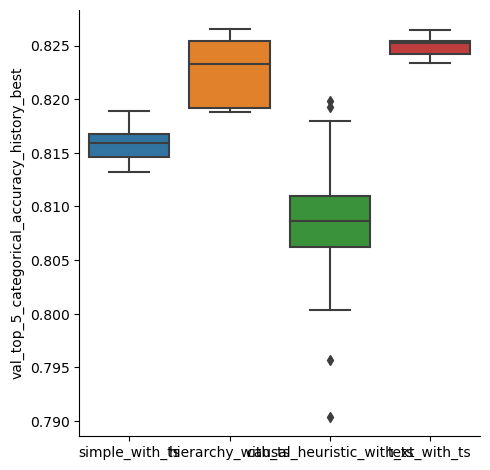

In [9]:
plot_best_metric_bar(lena_df, ['val_top_5_categorical_accuracy_history_best'],
x_order = ['simple_with_ts', 'hierarchy_with_ts', 'causal_heuristic_with_ts', 'text_with_ts'])

### Without Timestamps

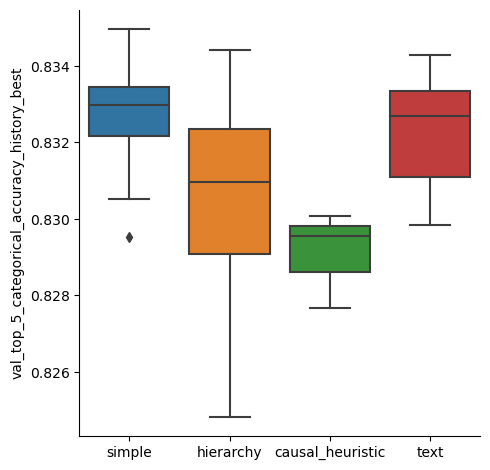

In [10]:
plot_best_metric_bar(lena_df, ['val_top_5_categorical_accuracy_history_best'],
x_order = ['simple', 'hierarchy', 'causal_heuristic', 'text'])

# Causal Algorithms' Results

## Graph Densities

In [11]:
knowledge_path = Path('/home/i40/almasrirz/Domain-Guided-Monitoring/data/knowledge_original')
pathlist = knowledge_path.glob('**/*.csv')
dataframes = {} # type -> df
for path in pathlist:
    if 'text' in path.name or 'hierarchy' in path.name:
        continue
    knowledge_type = path.name.split('_knowledge')[0]
    dataframes[knowledge_type] = pd.read_csv(path)

In [12]:
statistics = {'model_type': [], 'num_nodes': [], 'num_edges': []}
for name, df in dataframes.items():
    num_edges = len(df.index)
    num_nodes = len(set(df['parent_id'].tolist() + df['child_id'].tolist()))
    statistics['model_type'].append(name)
    statistics['num_edges'].append(num_edges)
    statistics['num_nodes'].append(num_nodes)
statistics = pd.DataFrame(statistics).sort_values(by=['model_type'])
statistics

,model_type,num_nodes,num_edges
38,causal_Fast-IAMB-jt_with_ts_large_none,284,284
24,causal_Fast-IAMB-jt_with_ts_large_small,314,316
26,causal_Fast-IAMB-jt_with_ts_medium_none,535,536
35,causal_Fast-IAMB-jt_with_ts_medium_small,661,665
34,causal_Fast-IAMB-jt_with_ts_small_None,863,926
14,causal_Fast-IAMB-jt_with_ts_small_none,863,926
40,causal_Fast-IAMB-jt_with_ts_small_small,848,923
7,causal_Fast-IAMB-jt_without_ts_large_large,322,324
27,causal_Fast-IAMB-jt_without_ts_large_medium,275,276
23,causal_Fast-IAMB-jt_without_ts_large_none,242,242


## Performance

In [13]:
# I used different bin sizes and bin overlaps for causal_Fast-IAMB-jt, causal_Fast-IAMB-smc-cor,
# and causal_MMPC-cor
# Bins used: 5 sec (small), 60 sec (medium), 10 min (large)
# Overlaps used as percentage of bin size: 0% (none), 20% (small), 50%
# (medium), 80% (large)
# Default is medium bin, large bin overlap
experimented_algos = ["causal_Fast-IAMB-jt", "causal_Fast-IAMB-smc-cor", "causal_MMPC-cor"]
run_df = mlflow_helper.run_df[
    (mlflow_helper.run_df['data_params_ExperimentConfigmax_data_size'] == '-1')
    & (mlflow_helper.run_df['data_tags_model_type'].isin(experimented_algos + ['simple']))
    & (mlflow_helper.run_df['data_params_HuaweiPreprocessorConfigaggregated_log_file'] == 'data/logs_aggregated_concurrent_original.csv')
]
run_df = mlflow_helper.load_best_metrics_for_ids(set(run_df["info_run_id"]))

Querying metrics for runs: 100%|██████████| 303/303 [00:33<00:00,  9.08it/s]


In [14]:
def categorize_run_df(run_df, experimented_algos = ["causal_Fast-IAMB-jt", "causal_Fast-IAMB-smc-cor", "causal_MMPC-cor"]):
    bin_configs = { # label -> (bin_size, bin_overlap)
        'small-none': (['00:00:05'], '00:00:00'),
        'medium-none': (['0:01:00','00:00:60'], '00:00:00'),
        'large-none': (['00:10:00'], '00:00:00'),
        'small-small': (['00:00:05'], '00:00:01'),
        'medium-small': (['0:01:00','00:00:60'], '00:00:12'),
        'large-small': (['00:10:00'], '00:02:00'),
        'small-medium': (['00:00:05'], '00:00:03'),
        'medium-medium': (['0:01:00','00:00:60'], '00:00:30'),
        'large-medium': (['00:10:00'], '00:05:00'),
        'small-large': (['00:00:05'], '00:00:04'),
        'medium-large': (['0:01:00','00:00:60'], '00:00:48'),
        'large-large': (['00:10:00'], '00:08:00'),
    }

    matrix_df = run_df.copy()
    for algo in experimented_algos:
        for label, config in bin_configs.items():
            bin_sizes, bin_overlap = config[0], config[1]
            matrix_df.loc[(matrix_df['data_params_TimeSeriesTransformerConfigbin_size'].isin(bin_sizes)) 
            & (matrix_df['data_params_TimeSeriesTransformerConfigbin_overlap'] == bin_overlap)
            & (matrix_df['data_tags_model_type'] == algo), 'data_tags_model_type'] = algo + '+' + label
    
    # Categorize by timestamps
    matrix_df.loc[matrix_df['data_params_HuaweiPreprocessorConfigremove_dates_from_payload'] == 'False', 'data_tags_model_type'] = matrix_df.loc[
    matrix_df['data_params_HuaweiPreprocessorConfigremove_dates_from_payload'] == 'False', 'data_tags_model_type'].apply(lambda x: x + '_with_ts')

    return matrix_df

# # More edges
# matrix_df.loc[
#     (matrix_df['data_params_HuaweiPreprocessorConfigcausal_algorithm_alpha'] == '0.1') & 
#     (matrix_df['data_params_HuaweiPreprocessorConfigfine_drain_log_depth'] == '10')
#     ,'data_tags_model_type'] = matrix_df.loc[
#     (matrix_df['data_params_HuaweiPreprocessorConfigcausal_algorithm_alpha'] == '0.1') & 
#     (matrix_df['data_params_HuaweiPreprocessorConfigfine_drain_log_depth'] == '10')
#               ,'data_tags_model_type'].apply(lambda x: x + 'high_alpha')

# # More templates
# matrix_df.loc[matrix_df['data_params_HuaweiPreprocessorConfigfine_drain_log_depth'] == '13','data_tags_model_type'] = matrix_df.loc[
#     matrix_df['data_params_HuaweiPreprocessorConfigfine_drain_log_depth'] == '13','data_tags_model_type'].apply(lambda x: x + 'more_fine')

In [15]:
matrix_df = categorize_run_df(run_df)

In [16]:
count_attributes(matrix_df)

data_tags_model_type
causal_Fast-IAMB-jt                         21
causal_Fast-IAMB-jt+large-medium            22
causal_Fast-IAMB-jt+large-none_with_ts       7
causal_Fast-IAMB-jt+large-small_with_ts      7
causal_Fast-IAMB-jt+medium-medium           15
causal_Fast-IAMB-jt+medium-none_with_ts     17
causal_Fast-IAMB-jt+medium-small_with_ts    16
causal_Fast-IAMB-jt+small-none               1
causal_Fast-IAMB-jt+small-none_with_ts      15
causal_Fast-IAMB-jt+small-small             20
causal_Fast-IAMB-jt+small-small_with_ts     15
causal_Fast-IAMB-smc-cor+medium-large       17
causal_Fast-IAMB-smc-cor+small-small        19
causal_MMPC-cor+large-medium                 3
causal_MMPC-cor+large-small                 20
causal_MMPC-cor+medium-large                16
causal_MMPC-cor+medium-medium               16
causal_MMPC-cor+small-large                 16
simple                                      20
simple_with_ts                              20
Name: data_tags_model_type, dtype: int6

In [17]:
sorted_top_5_accuracy_median_df = pd.DataFrame(
    matrix_df.groupby(['data_tags_model_type'])['val_top_5_categorical_accuracy_history_best']
    .median()
    .sort_values(ascending=False)).reset_index()
sorted_top_5_accuracy_median_df

,data_tags_model_type,val_top_5_categorical_accuracy_history_best
0,causal_Fast-IAMB-jt+small-small,0.833957
1,causal_Fast-IAMB-smc-cor+small-small,0.833628
2,causal_Fast-IAMB-jt+small-none,0.833443
3,causal_Fast-IAMB-jt,0.833343
4,causal_Fast-IAMB-smc-cor+medium-large,0.833329
5,causal_Fast-IAMB-jt+large-medium,0.833114
6,simple,0.832964
7,causal_MMPC-cor+large-medium,0.832886
8,causal_MMPC-cor+medium-large,0.832772
9,causal_Fast-IAMB-jt+medium-medium,0.832757


In [18]:
# Sort by mean top 5 categorical accuracy
sorted_top_5_accuracy_mean_df = pd.DataFrame(
    matrix_df.groupby(['data_tags_model_type'])['val_top_5_categorical_accuracy_history_best']
    .mean()
    .sort_values(ascending=False)).reset_index()
sorted_top_5_accuracy_mean_df

,data_tags_model_type,val_top_5_categorical_accuracy_history_best
0,causal_Fast-IAMB-jt+small-small,0.834112
1,causal_Fast-IAMB-smc-cor+small-small,0.833637
2,causal_Fast-IAMB-jt+small-none,0.833443
3,causal_Fast-IAMB-smc-cor+medium-large,0.833210
4,causal_Fast-IAMB-jt,0.832977
5,causal_MMPC-cor+medium-large,0.832930
6,causal_Fast-IAMB-jt+large-medium,0.832924
7,simple,0.832727
8,causal_MMPC-cor+large-medium,0.832672
9,causal_MMPC-cor+small-large,0.832666


In [19]:
k = 3
# Without timestamps
top_k_mean_no_ts = sorted_top_5_accuracy_mean_df['data_tags_model_type'].tolist()[:k]
top_k_median_no_ts = sorted_top_5_accuracy_median_df['data_tags_model_type'].tolist()[:k]

if "simple" not in top_k_mean_no_ts:
    top_k_mean_no_ts.append('simple')

if "simple" not in top_k_median_no_ts:
    top_k_median_no_ts.append('simple')

# With timestamps
top_k_mean_ts = list(filter(lambda x: x.endswith('with_ts'),sorted_top_5_accuracy_mean_df['data_tags_model_type'].tolist()))[:k]
top_k_median_ts = list(filter(lambda x: x.endswith('with_ts'),sorted_top_5_accuracy_median_df['data_tags_model_type'].tolist()))[:k]

if "simple_with_ts" not in top_k_mean_ts:
    top_k_mean_ts.append('simple_with_ts')

if "simple_with_ts" not in top_k_median_ts:
    top_k_median_ts.append('simple_with_ts')

['causal_Fast-IAMB-jt+small-small_with_ts', 'causal_Fast-IAMB-jt+small-none_with_ts', 'causal_Fast-IAMB-jt+large-small_with_ts', 'simple_with_ts']


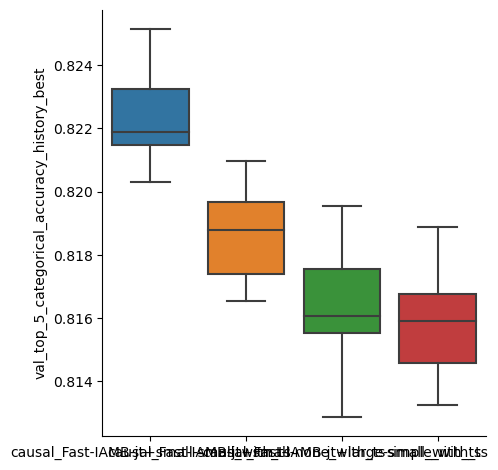

In [20]:
print(top_k_mean_ts)
plot_best_metric_bar(matrix_df, ['val_top_5_categorical_accuracy_history_best'],
x_order = top_k_mean_ts)

['causal_Fast-IAMB-jt+small-small_with_ts', 'causal_Fast-IAMB-jt+small-none_with_ts', 'causal_Fast-IAMB-jt+large-small_with_ts', 'simple_with_ts']


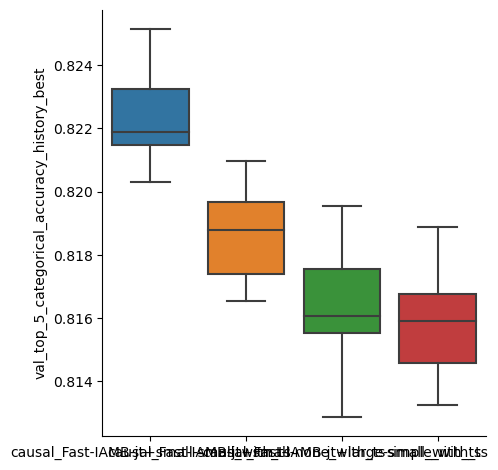

In [21]:
print(top_k_median_ts)
plot_best_metric_bar(matrix_df, ['val_top_5_categorical_accuracy_history_best'],
x_order = top_k_median_ts)

['causal_Fast-IAMB-jt+small-small', 'causal_Fast-IAMB-smc-cor+small-small', 'causal_Fast-IAMB-jt+small-none', 'simple']


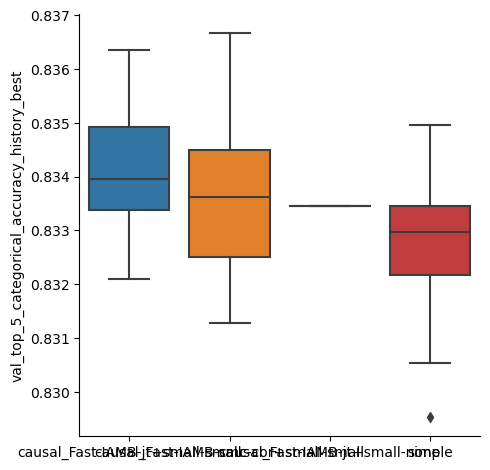

In [22]:
print(top_k_mean_no_ts)
plot_best_metric_bar(matrix_df, ['val_top_5_categorical_accuracy_history_best'],
x_order = top_k_mean_no_ts)

['causal_Fast-IAMB-jt+small-small', 'causal_Fast-IAMB-smc-cor+small-small', 'causal_Fast-IAMB-jt+small-none', 'simple']


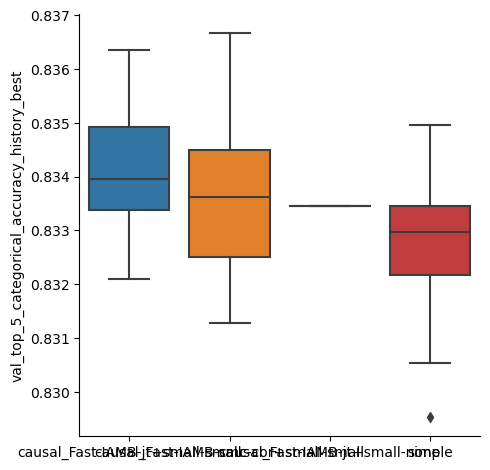

In [23]:
print(top_k_median_no_ts)
plot_best_metric_bar(matrix_df, ['val_top_5_categorical_accuracy_history_best'],
x_order = top_k_median_no_ts)

In [24]:
test_df = mlflow_helper.run_df[
    (mlflow_helper.run_df['data_params_ExperimentConfigmax_data_size'] == '-1')
    & (mlflow_helper.run_df['data_params_HuaweiPreprocessorConfigaggregated_log_file'] == 'data/logs_aggregated_concurrent_original.csv')
]
test_df = mlflow_helper.load_best_metrics_for_ids(set(test_df["info_run_id"]))
test_matrix_df = categorize_run_df(test_df)
count_attributes(test_matrix_df)

Querying metrics for runs:   1%|          | 3/398 [00:38<1:21:27, 12.37s/it]

Error! Best Metric not in metric_dict val_loss_history 2a4414ef7f2a424c9adabfd387b4859e


Querying metrics for runs:  11%|█▏        | 45/398 [00:43<00:34, 10.20it/s] 

Error! Best Metric not in metric_dict val_loss_history 8d903dd006fa4334a2bdff2599292be1


Querying metrics for runs:  46%|████▌     | 183/398 [00:58<00:19, 11.06it/s]

Error! Best Metric not in metric_dict val_loss_history 4c3462aff05d4bfe8193749cce493240


Querying metrics for runs:  61%|██████▏   | 244/398 [01:05<00:14, 10.67it/s]

Error! Best Metric not in metric_dict val_loss_history eb83ad31162d48caa9804f741dbdd328


Querying metrics for runs:  77%|███████▋  | 308/398 [01:12<00:08, 10.88it/s]

Error! Best Metric not in metric_dict val_loss_history 10bd61e6666b451092474c78f063b78e


Querying metrics for runs:  80%|███████▉  | 317/398 [01:13<00:07, 11.01it/s]

Error! Best Metric not in metric_dict val_loss_history 40ba8781fff4459e9f68165c76431bdb


Querying metrics for runs:  95%|█████████▌| 379/398 [01:20<00:01, 10.99it/s]

Error! Best Metric not in metric_dict val_loss_history 444dbd1e5d40404484987612fabd3a88


Querying metrics for runs: 100%|██████████| 398/398 [01:22<00:00,  4.83it/s]


data_tags_model_type
causal_Fast-IAMB-jt                         21
causal_Fast-IAMB-jt+large-medium            22
causal_Fast-IAMB-jt+large-none_with_ts       7
causal_Fast-IAMB-jt+large-small_with_ts      7
causal_Fast-IAMB-jt+medium-medium           15
causal_Fast-IAMB-jt+medium-none_with_ts     17
causal_Fast-IAMB-jt+medium-small_with_ts    16
causal_Fast-IAMB-jt+small-none               1
causal_Fast-IAMB-jt+small-none_with_ts      15
causal_Fast-IAMB-jt+small-small             20
causal_Fast-IAMB-jt+small-small_with_ts     15
causal_Fast-IAMB-smc-cor+medium-large       17
causal_Fast-IAMB-smc-cor+small-small        19
causal_MMPC-cor+large-medium                 3
causal_MMPC-cor+large-small                 20
causal_MMPC-cor+medium-large                16
causal_MMPC-cor+medium-medium               16
causal_MMPC-cor+small-large                 16
causal_heuristic                             3
causal_heuristic_with_ts                    20
hierarchy                              

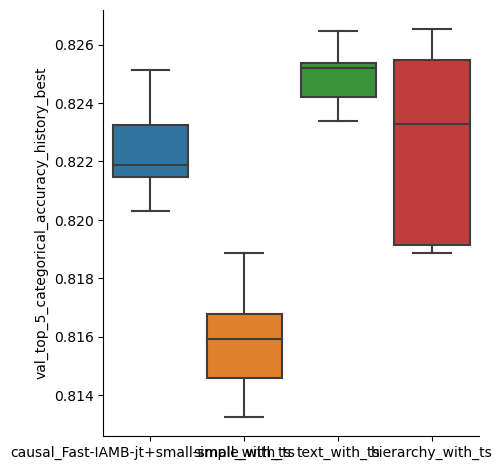

In [25]:
plot_best_metric_bar(test_matrix_df, ['val_top_5_categorical_accuracy_history_best'],
x_order = ['causal_Fast-IAMB-jt+small-small_with_ts', 'simple_with_ts', 'text_with_ts', 'hierarchy_with_ts'])